# Phoneme Classifier Results
### Author: Cathal Ó Faoláin
### 16:57, 29/08/2024

The goal of this work is to understand how we can use predicted IHC potentials, such as those predicted by WavIHC, introduced in the paper "WaveNet-based approximation of a cochlear filtering and hair cell transduction model".  Feature encoders designed to use these predicted IHC potentials are evaluated against other state-of-the-art feature encoders in order to understand how discriminating they are, and over a range of different Signal-to-Noise Ratios (SNRs).

This notebook describes the networks we are evaluating and their results. We have 9 feature encoders:

- Contrastive Predictive Coding (CPC) 
- Wav2vec2.0
- Autoregressive Predictive Coding (APC)
- IHC CPC
- IHC CPC 80
- IHC Wav2vec2
- IHC Wav2vec2 80
- IHC Extract
- IHC Extract 512

This should grant us with a much better understanding of our models, their limitations and advantages.

The first three feature encoders, CPC, Wav2vec2.0 and APC are based on the designs used in each of the papers. Any context encoders that tries to model longer-term dependencies have been removed - so no transformers or Recurrent Neural Networks (RNN). This is to allow for us to evaluate how discriminating the features themselves are. 

IHC CPC and Wav2vec2 are adapted feature encoders that take predicted IHC potentials as input rather than the signal alone. Each is inspired by their namesake models.

In [1]:
import torch
from torch import nn
import librosa
import time
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch.utils.data import DataLoader, Dataset, IterableDataset
import torchaudio
import pandas as pd
import numpy as np
import time
import sys
import yaml
import math
import pickle
import scipy.signal as signal
from dataclasses import dataclass, field
from typing import List, Tuple
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
sys.path.append('./IHCApproxNH/')
from classes import WaveNet
from utils import utils
from Encoders import FeatureEncoders 
from TIMIT_utils import TIMIT_utils
from Train_TestFunctions import TrainEvalFunctions
!pip install openpyxl


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Set Global Learning Settings

In [3]:
EPOCHS=100
learning_rate=0.01

## Model Parameter Descriptor

In [4]:
model_dict, trainable_dict=TrainEvalFunctions.all_models_parameters()

params_df=pd.DataFrame({ 'Total Parameters':model_dict, 'Trainable Parameters':trainable_dict})

params_df['Frozen Parameters']=params_df["Total Parameters"]-params_df["Trainable Parameters"]

params_df.sort_values(by=['Trainable Parameters'], inplace=True)

params_df

> Initialising model: Wav2Vec2.0
> Initialising model: CPC
> Initialising model: MelSimple
> Initialising model: MelSimple_MLP
> Initialising model: Wav2Vec2.0_80
> Initialising model: CPC_80
> Initialising model: IHC_CPC
> Initialising model: IHC_CPC_80
> Initialising model: IHC_Wav2Vec2_80
> Initialising model: IHC_Wav2Vec2
> Initialising model: IHC_Extract
> Initialising model: IHC_Extract_512
> Initialising model: IHC_Extract_2.0
> Initialising model: SIG_Extract
> Initialising model: SIG_Extract_512
> Initialising model: SIG_Extract_2.0


,Total Parameters,Trainable Parameters,Frozen Parameters
MelSimple,3159,3159,0
Wav2vec2_80,106519,106519,0
SIG_Extract_2.0,113834,113834,0
CPC_80,131959,131959,0
SIG_Extract,137184,137184,0
IHC_Wav2vec2_80,3698875,169719,3529156
IHC_Extract_2.0,3706190,177034,3529156
IHC_Cpc_80,3724315,195159,3529156
IHC_Extract,3729540,200384,3529156
MelSimple_MLP,586791,586791,0


In [5]:
model_dict, trainable_dict=TrainEvalFunctions.all_models_parameters()

params_df=pd.DataFrame({ 'Total Parameters':model_dict, 'Trainable Parameters':trainable_dict})

params_df['Frozen Parameters']=params_df["Total Parameters"]-params_df["Trainable Parameters"]

params_df.sort_values(by=['Trainable Parameters'], inplace=True)

params_df

> Initialising model: Wav2Vec2.0
> Initialising model: CPC
> Initialising model: MelSimple
> Initialising model: MelSimple_MLP
> Initialising model: Wav2Vec2.0_80
> Initialising model: CPC_80
> Initialising model: IHC_CPC
> Initialising model: IHC_CPC_80
> Initialising model: IHC_Wav2Vec2_80
> Initialising model: IHC_Wav2Vec2
> Initialising model: IHC_Extract
> Initialising model: IHC_Extract_512
> Initialising model: IHC_Extract_2.0
> Initialising model: SIG_Extract
> Initialising model: SIG_Extract_512
> Initialising model: SIG_Extract_2.0


,Total Parameters,Trainable Parameters,Frozen Parameters
MelSimple,3159,3159,0
Wav2vec2_80,106519,106519,0
SIG_Extract_2.0,113834,113834,0
CPC_80,131959,131959,0
SIG_Extract,137184,137184,0
IHC_Wav2vec2_80,3698875,169719,3529156
IHC_Extract_2.0,3706190,177034,3529156
IHC_Cpc_80,3724315,195159,3529156
IHC_Extract,3729540,200384,3529156
MelSimple_MLP,586791,586791,0


## K-Fold Evaluation Clean Results
This is to show how the model performance varies over multiple runs with different data. Some data is omitted from training and instead used as a new validation. The test data the performance is tested on remains the same as in regular training.

In [6]:
def model_check(x):
    designation_type={"wav2vec2_80":"W2V_small", "wav2vec2": "W2V",  "cpc_80": "CPC_small", "cpc": "CPC", "mel": "APC", "extract_2.0": "AFE2", "extract_512" : "AFE_large", "extract" : "AFE"}
    model_types= ["wav2vec2_80", "wav2vec2", "cpc_80","cpc", "mel", "extract_2.0", "extract_512", "extract"]
    for model in model_types:
        if model in x.lower():
            return designation_type[model]

    return "None"

In [7]:
#For the original models
original_models=["Wav2vec2", "CPC", "Mel", "Extract"]

with open('Results/k-Fold Stability/original_models.pkl', 'rb') as f:
    loaded_test = pickle.load(f)

#Split the dataframe into Model and kFold
df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
df=df.reset_index()
df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG")
df["Model Type"]=df["Model"].apply(model_check)
df.drop(columns=["index"], inplace=True)
df

,Accuracy,Model,kFold,Input Type,Model Type
0,0.574288,Wav2vec2,1,SIG,W2V
1,0.578899,Wav2vec2,2,SIG,W2V
2,0.579573,Wav2vec2,3,SIG,W2V
3,0.577559,Wav2vec2,4,SIG,W2V
4,0.581066,Wav2vec2,5,SIG,W2V
5,0.591565,Wav2vec2_80,1,SIG,W2V_small
6,0.593335,Wav2vec2_80,2,SIG,W2V_small
7,0.593335,Wav2vec2_80,3,SIG,W2V_small
8,0.590863,Wav2vec2_80,4,SIG,W2V_small
9,0.588961,Wav2vec2_80,5,SIG,W2V_small


In [8]:
#For the original models
original_models=["IHC_Cpc", "IHC_Cpc_80","IHC_Wav2vec2_80", "IHC_Wav2vec2", "IHC_Extract", "IHC_Extract_512", "IHC_Extract_2.0"]

with open('Results/k-Fold Stability/IHC_models.pkl', 'rb') as f:
    loaded_test = pickle.load(f)
    
#Split the dataframe into Model and kFold
IHC_df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
IHC_df=IHC_df.reset_index()
IHC_df[['Model', 'kFold']]=[(x[0], x[2]) for x in IHC_df['index'].str.split('-')]
IHC_df.drop(columns=["index"], inplace=True)
IHC_df["Input Type"]="IHC"
IHC_df["Model Type"]=IHC_df["Model"].apply(model_check)
IHC_df

,Accuracy,Model,kFold,Input Type,Model Type
0,0.637254,IHC_Extract_2.0,1,IHC,AFE2
1,0.634174,IHC_Extract_2.0,2,IHC,AFE2
2,0.638153,IHC_Extract_2.0,3,IHC,AFE2
3,0.631992,IHC_Extract_2.0,4,IHC,AFE2
4,0.635095,IHC_Extract_2.0,5,IHC,AFE2
5,0.581603,IHC_Cpc,1,IHC,CPC
6,0.577671,IHC_Cpc,2,IHC,CPC
7,0.574132,IHC_Cpc,3,IHC,CPC
8,0.574504,IHC_Cpc,4,IHC,CPC
9,0.578075,IHC_Cpc,5,IHC,CPC


Let us visualise the performance on phoneme accuracy of related models when they use either the pure signal, or the predicted IHC potentials.

In [9]:
combined_models=pd.concat([IHC_df, df], ignore_index=True)

designations={"MelSimple":"MEL_APC_small","MelSimple_MLP": "MEL_APC", "CPC" : "SIG_CPC",\
              "IHC_Cpc": "IHC_CPC", "CPC_80": "SIG_CPC_small", "IHC_Cpc_80": "IHC_CPC_small", "Wav2vec2": "SIG_W2V","IHC_Wav2vec2": "IHC_W2V",\
"Wav2vec2_80":"SIG_W2V_small", "IHC_Wav2vec2_80": "IHC_W2V_small", "SIG_Extract": "SIG_AFE", "IHC_Extract":"IHC_AFE",\
              "SIG_Extract_512": "SIG_AFE_large", "IHC_Extract_512": "IHC_AFE_large", "SIG_Extract_2.0":"SIG_AFE2", "IHC_Extract_2.0":"IHC_AFE2"}

combined_models["PER"]=1-combined_models["Accuracy"]
combined_models["Designation"]=combined_models["Model"].apply(lambda x: designations[x])

combined_models

,Accuracy,Model,kFold,Input Type,Model Type,PER,Designation
0,0.637254,IHC_Extract_2.0,1,IHC,AFE2,0.362746,IHC_AFE2
1,0.634174,IHC_Extract_2.0,2,IHC,AFE2,0.365826,IHC_AFE2
2,0.638153,IHC_Extract_2.0,3,IHC,AFE2,0.361847,IHC_AFE2
3,0.631992,IHC_Extract_2.0,4,IHC,AFE2,0.368008,IHC_AFE2
4,0.635095,IHC_Extract_2.0,5,IHC,AFE2,0.364905,IHC_AFE2
...,...,...,...,...,...,...,...
75,0.646962,SIG_Extract_2.0,1,SIG,AFE2,0.353038,SIG_AFE2
76,0.648365,SIG_Extract_2.0,2,SIG,AFE2,0.351635,SIG_AFE2
77,0.647823,SIG_Extract_2.0,3,SIG,AFE2,0.352177,SIG_AFE2
78,0.628811,SIG_Extract_2.0,4,SIG,AFE2,0.371189,SIG_AFE2


In [10]:
#Get the list of model types
types=combined_models["Model Type"].unique()

order=['APC', 'CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large',
       'AFE2']
order

['APC', 'CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large', 'AFE2']

Split into a list of models from the same kFold

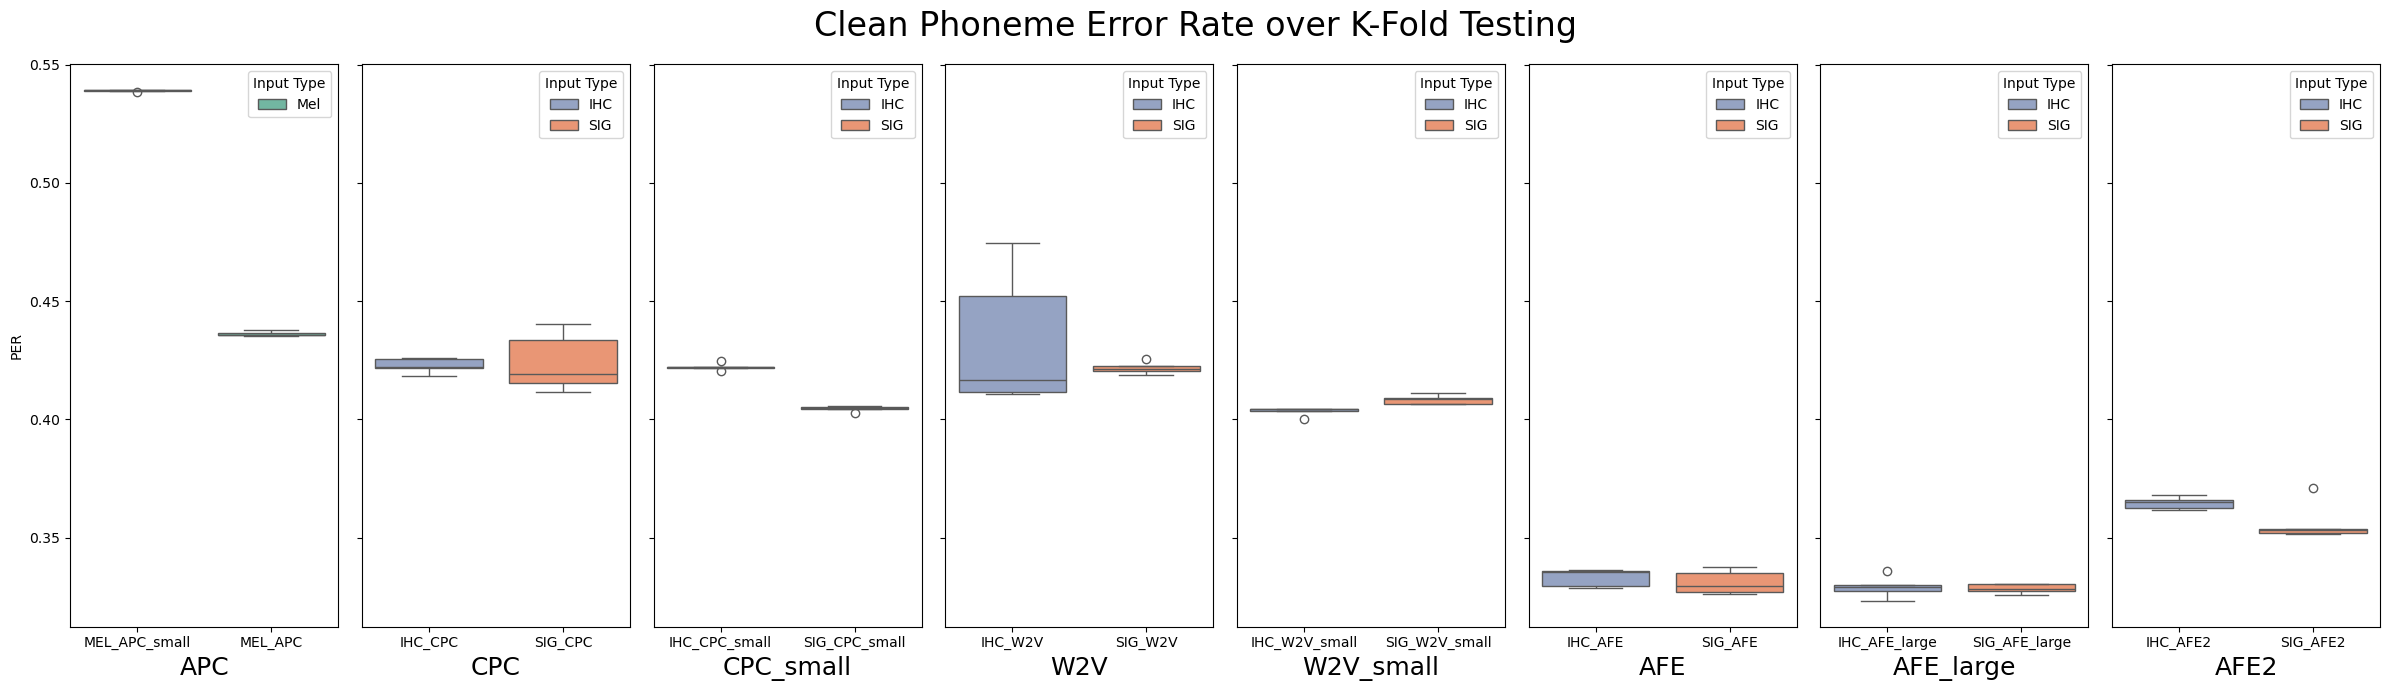

In [11]:
import seaborn as sns

fig, (ax) =plt.subplots(ncols=8, sharey=True, figsize=(24,7))

colours={"Mel":"#66c2a5", "IHC": "#8da0cb", "SIG": "#fc8d62"}

for i, type in enumerate(order):
        
    subset=combined_models[combined_models["Model Type"]==type]
    
    sns.boxplot( x="Designation", y="PER", hue="Input Type", palette=colours, data=subset, ax=ax[i])
    ax[i].set_xlabel("{}".format(type), fontsize=18)
    

plt.ylabel("Phoneme Error Rate (PER)", fontsize=22)
fig.suptitle("Clean Phoneme Error Rate over K-Fold Testing", fontsize=24)
fig.tight_layout()


Fist we will need to get the dataframe for the original models and combine all the SNRs. Next, we will loop through and get the model's average PER, the standard deviation of PER at every SNR.

In [12]:
SNRs=[30, 25, 20, 15, 10, 5, 0, -5, -10]

In [13]:
designations={"MelSimple":"MEL_APC_small","MelSimple_MLP": "MEL_APC", "CPC" : "SIG_CPC",\
              "IHC_Cpc": "IHC_CPC", "CPC_80": "SIG_CPC_small", "IHC_Cpc_80": "IHC_CPC_small", "Wav2vec2": "SIG_W2V","IHC_Wav2vec2": "IHC_W2V",\
"Wav2vec2_80":"SIG_W2V_small", "IHC_Wav2vec2_80": "IHC_W2V_small", "SIG_Extract": "SIG_AFE", "IHC_Extract":"IHC_AFE",\
              "SIG_Extract_512": "SIG_AFE_large", "IHC_Extract_512": "IHC_AFE_large", "SIG_Extract_2.0":"SIG_AFE2", "IHC_Extract_2.0":"IHC_AFE2"}

def model_check(x):
    designation_type={"wav2vec2_80":"W2V_small", "wav2vec2": "W2V",  "cpc_80": "CPC_small", "cpc": "CPC", "mel": "APC", "extract_2.0": "AFE2", "extract_512" : "AFE_large", "extract" : "AFE"}
    model_types= ["wav2vec2_80", "wav2vec2", "cpc_80","cpc", "mel", "extract_2.0", "extract_512", "extract"]
    for model in model_types:
        if model in x.lower():
            return designation_type[model]

    return "None"

In [14]:
def model_noise_reaction(noise, model="AFE2"):
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()
    ########################
    for type in model_input:
        #Get all the snrs that were tested 
        for snr in SNRs:
            with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                loaded_test = pickle.load(f)

            #Split the dataframe into Model and kFold
            df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
            df=df.reset_index()
            df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
            if type=="original":
                df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
            elif type=="IHC":
                df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
            df["Model Type"]=df["Model"].apply(model_check)
            df.drop(columns=["index"], inplace=True)
            df['SNR']=snr
            df['Noise Type']=noise
            df["PER"]=1-df["Accuracy"]
            df["Designation"]=df["Model"].apply(lambda x: designations[x])
            df.reset_index()
    
            #Concatenate this loaded test to other dataframes
            noisy_df=pd.concat([noisy_df, df], ignore_index=True)
    ###################################
    #Get the range of different model performance for each designation
    models=noisy_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Designation", "SNR", "Model Type"]].groupby(["Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Designation", "SNR", "Input Type"]].groupby(["Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    fig, (ax)=plt.subplots(figsize=(12, 7))

    types=noisy_df["Model Type"].unique()
    order=['APC', 'CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large',
       'AFE2']

    for ii, type in enumerate(order):
        subset=mean_PER[mean_PER["Noise Type"]==type]
        subset[subset["Model Type"]==model]
        models=subset["Designation"].unique()
        
        for m in models:
            sub_PER=subset[subset["Designation"]==m]
            input=sub_PER["Input Type"].iloc[0]
            sub_PER= sub_PER.sort_values("SNR", ascending=True)
        
            ax.plot(sub_PER["SNR"], sub_PER["PER"], color=line_colour[input], label=labels[input])
            ax.fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.5)
            ax.set_ylim(0.3, 1)
            ax.legend(fontsize=16)
            ax.set_title("%s Model in Noise %s " %(type))
            #ax.invert_xaxis()

            

    

    plt.ylabel("Phoneme Error Rate (PER)", fontsize=20)
    plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)

    fig.suptitle("Phoneme Recognition in {} Noise, k-Fold Testing".format(noise), fontsize=24)

    fig.tight_layout()

In [15]:
def model_noise_reaction(model):
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()

    for noise in noise:
        ########################
        for type in model_input:
            #Get all the snrs that were tested 
            for snr in SNRs:
                with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                    loaded_test = pickle.load(f)

                #Split the dataframe into Model and kFold
                df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
                df=df.reset_index()
                df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
                if type=="original":
                    df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
                elif type=="IHC":
                    df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
                df["Model Type"]=df["Model"].apply(model_check)
                df.drop(columns=["index"], inplace=True)
                df['SNR']=snr
                df['Noise Type']=noise
                df["PER"]=1-df["Accuracy"]
                df["Designation"]=df["Model"].apply(lambda x: designations[x])
                df.reset_index()
    
                #Concatenate this loaded test to other dataframes
                noisy_df=pd.concat([noisy_df, df], ignore_index=True)
    ###################################
    #Get the range of different model performance for each designation
    noisy_df=noisy_df[noisy_df["Designation"]==model]

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type" "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Noise Type", "SNR", "Model Type"]].groupby(["Noise Type", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Noise Type", "SNR", "Input Type"]].groupby(["Noise Type", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    fig, (ax)=plt.subplots(nrows=2, ncols=4, figsize=(28, 14))

    types=noisy_df["Noise Type"].unique()
    #order=['APC', 'CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large',
    #   'AFE2']

    for ii, type in enumerate(order):
        subset=mean_PER[mean_PER["Noise Type"]==type]
        models=subset["Designation"].unique()

        j=ii%4
        i=(ii//4)
 
        for model in models:
        
            sub_PER=subset[subset["Designation"]==model]
            input=sub_PER["Input Type"].iloc[0]
            sub_PER= sub_PER.sort_values("SNR", ascending=True)
        
            ax[i, j].plot(sub_PER["SNR"], sub_PER["PER"], color=line_colour[input], label=labels[input])
            ax[i, j].fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.5)
            ax[i, j].set_ylim(0.3, 1)
            ax[i, j].legend(fontsize=16)
            ax[i, j].set_title("%s Model in Noise %s " %(type)
            ax[i, j].invert_xaxis()
            #Plot what happens if you simply predict the main phoneme type every time
            

    

    plt.ylabel("Phoneme Error Rate (PER)", fontsize=20)
    plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)

    fig.suptitle("Phoneme Recognition in {} Noise, k-Fold Testing".format(noise), fontsize=24)

    fig.tight_layout()

SyntaxError: '(' was never closed (2494052420.py, line 77)

In [16]:
def noise_table(noise):
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()

    SNRs=[30, 25, 20, 15, 10, 5, 0, -5, -10]
    ########################
    for type in model_input:
        #Get all the snrs that were tested 
        for snr in SNRs:
            with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                loaded_test = pickle.load(f)

            #Split the dataframe into Model and kFold
            df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
            df=df.reset_index()
            df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
            if type=="original":
                df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
            elif type=="IHC":
                df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
            df["Model Type"]=df["Model"].apply(model_check)
            df.drop(columns=["index"], inplace=True)
            df['SNR']=snr
            df['Noise Type']=noise
            df["PER"]=1-df["Accuracy"]
            df["Designation"]=df["Model"].apply(lambda x: designations[x])
            df.reset_index()
    
            #Concatenate this loaded test to other dataframes
            noisy_df=pd.concat([noisy_df, df], ignore_index=True)
            noisy_df.to_excel("total_results.xlsx")
            
    ###################################
    #Get the range of different model performance for each designation
    models=noisy_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Designation", "SNR", "Model Type"]].groupby(["Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Designation", "SNR", "Input Type"]].groupby(["Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()

    mean_PER.to_excel("mean_results.xlsx")
    
    order=['CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large',
       'AFE2']
    difference_df=pd.DataFrame(columns=["Model Type", "SNR", "PER"])

    
    list_rows=[]
    ##########################################
    for type in order:
        subset=mean_PER[mean_PER["Model Type"]==type]
        models=subset["Designation"].unique()

        #print("Model Type:: %s" %type)
        row_dict={}
        row_dict["Model Type"]=type
        
        #average_increase=[0, 0, 0, 0, 0, 0, 0, 0, 0]
        #Get the snr for each
        for snr in SNRs:
            #string_snr+="%s     |  " %snr
            mini_PER=subset[subset["SNR"]==snr]
            signal_PER=mini_PER[mini_PER["Input Type"]=="SIG"].iloc[0]
            IHC_PER=mini_PER[mini_PER["Input Type"]=="IHC"].iloc[0]
            #string+= "%0.4f  | " %((signal_PER["PER"]-IHC_PER["PER"])*100)
            average_increase=(signal_PER["PER"]-IHC_PER["PER"])*100
            row_dict[snr]=average_increase
            
        list_rows.append(row_dict)
    table=pd.DataFrame(list_rows)
    print(table)

In [17]:
noise_types=["White", "air_conditioner", "children_playing","dog_bark",  "street_music"]

for noise in noise_types:
    print("*** Noise Type: {} ***".format(noise))
    noise_table(noise)
    print()
    print()
    print()

*** Noise Type: White ***
  Model Type         30         25         20        15        10         5  \
0        CPC -13.220887  -2.684290  -0.498905  0.604992  3.066838  4.332119   
1  CPC_small -14.157746  -3.343399  -1.635273  0.049061  3.385129  5.262806   
2        W2V   6.782377  13.608215  11.789546  8.024119  3.784189  3.808893   
3  W2V_small   7.600097  13.914116  11.620785  8.145089  4.172297  3.362089   
4        AFE  -6.417805  -2.652347  -1.671408 -0.661831  0.534037  2.222531   
5  AFE_large  -4.592149  -3.141908  -2.059684 -1.501970 -0.987149 -0.756780   
6       AFE2   8.467167  13.216015  12.382175  8.922697  5.090005  4.156436   

          0        -5       -10  
0  2.981122  1.253087  0.680277  
1  3.793629  1.719380  1.035791  
2  5.475854  6.016473  5.153389  
3  4.282722  4.694175  3.929244  
4  2.168100  2.146229  2.518262  
5 -0.402936 -0.037441  0.148878  
6  4.240756  4.195984  3.864653  



*** Noise Type: air_conditioner ***
  Model Type        30        

## Does using IHCs improve Phoneme Error Rate (PER) in Noise?

In [120]:
def IHC_noise_PER(noise, intervals=[30, 10, -10]):
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()
    ########################
    for type in model_input:
        #Get all the snrs that were tested 
        for snr in SNRs:
            with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                loaded_test = pickle.load(f)

            #Split the dataframe into Model and kFold
            df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
            df=df.reset_index()
            df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
            if type=="original":
                df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
            elif type=="IHC":
                df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
            df["Model Type"]=df["Model"].apply(model_check)
            df.drop(columns=["index"], inplace=True)
            df['SNR']=snr
            df['Noise Type']=noise
            df["PER"]=1-df["Accuracy"]
            df["Designation"]=df["Model"].apply(lambda x: designations[x])
            df.reset_index()
    
            #Concatenate this loaded test to other dataframes
            noisy_df=pd.concat([noisy_df, df], ignore_index=True)
    ###################################
    #Get the range of different model performance for each designation
    models=noisy_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Designation", "SNR", "Model Type"]].groupby(["Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Designation", "SNR", "Input Type"]].groupby(["Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}
    markers={"SIG": "^", "Mel": "o", "IHC": "D"}

    fig, (ax)=plt.subplots(ncols=3, figsize=(16, 10))

    types=noisy_df["Model Type"].unique()
    order=['APC', 'CPC', 'W2V', 'AFE',
       'AFE2']

    mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER=mean_PER[mean_PER["Designation"]!="MEL_APC_small"]

    noisy_df=noisy_df[noisy_df["Model Type"].isin(order)]
    noisy_df=noisy_df[noisy_df["Designation"]!="MEL_APC_small"]
    differences={}
    #Plot each snr
    for ii, snr in enumerate(intervals):
        #Get the subset at the SNR value
        #Get the max difference between input sizes of the same PER
        y_size=0.0
        for i, n in enumerate(noisy_df["SNR"].unique()):
            subcheck=noisy_df[noisy_df["SNR"]==n]
            y_now=max(subcheck["PER"]) - min(subcheck["PER"])+0.02
            if i==0:
                y_size=y_now
            elif y_now > y_size:
                y_size=y_now
        print(y_size)

        subset=noisy_df[noisy_df["SNR"]==snr]
        sub_mean=mean_PER[mean_PER["SNR"]==snr]
        #print(subset)
        inputs=["Mel", "SIG", "IHC"]
        
        for input in inputs:
            #sub_PER=subset[subset["Input Type"]==input]
            sub_PER=sub_mean[sub_mean["Input Type"]==input]
            #ax[ii].scatter(means["Designation"], means["PER"], c=line_colour[means["Input Type"].iloc[0]], label=input, s=90, marker='_')
            ax[ii].scatter(sub_PER["Designation"], sub_PER["PER"], c=line_colour[sub_PER["Input Type"].iloc[0]], label=input, s=150, marker=markers[sub_PER["Input Type"].iloc[0]], alpha=0.65)#, label=labels)
            #ax[ii].errorbar(sub_PER["Designation"], sub_PER["PER"], yerr=sub_PER["std"], c=line_colour[sub_PER["Input Type"].iloc[0]], fmt='o')

            if input=="SIG":
                #print("in if")
                #print(sub_PER["PER"])
                sig_models=sub_PER["PER"].to_numpy()
                #print("in if")

        IHC_models=sub_PER["PER"].to_numpy()
        print(np.subtract(sig_models, IHC_models))
        print("At SNR %s, the average difference in performance is %f. \n" %(snr, np.average(np.subtract(sig_models, IHC_models))))
        
        
       # ax[ii].fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.5)
        #ax[ii].set_ylim(0.3, 1)
        ax[ii].legend(fontsize=16)
        ax[ii].set_title("At SNR: %s " %snr, fontsize=24)
        ax[ii].set_ylabel("Phoneme Error Rate (PER)", fontsize=20)
        #ax[ii].set_xlabel("Model Designation", fontsize=20)
        ax[ii].tick_params(axis='x', rotation=60, labelsize=14)
        ax[ii].tick_params(axis='y', labelsize=14)

        y_min=min(subset["PER"])
        if(y_min+y_size<=1):
            ax[ii].set_ylim(y_min, y_min+y_size)
        else:
            ax[ii].set_ylim(1-y_size, 1)
        
        
        #ax[ii].set_xticklabels(ax[ii].get_xticks(), rotation=60, fontsize=18)
#ax[ii].invert_xaxis()
        #Plot what happens if you simply predict the main phoneme type every time
            

    fig.suptitle("Phoneme Recognition in {} Noise".format(noise), fontsize=26)

    fig.tight_layout()

    plt.savefig("Graphs/PER_in_{}.pdf".format(noise), format="pdf", bbox_inches="tight")

0.263703592183705
[-0.0032926  -0.01032126  0.0049751  -0.01309777]
At SNR 30, the average difference in performance is -0.005434. 

0.263703592183705
[0.07009002 0.04684468 0.05954527 0.04456226]
At SNR 10, the average difference in performance is 0.055261. 

0.263703592183705
[ 0.04412809  0.05127362 -0.00316777  0.03853355]
At SNR -10, the average difference in performance is 0.032692. 



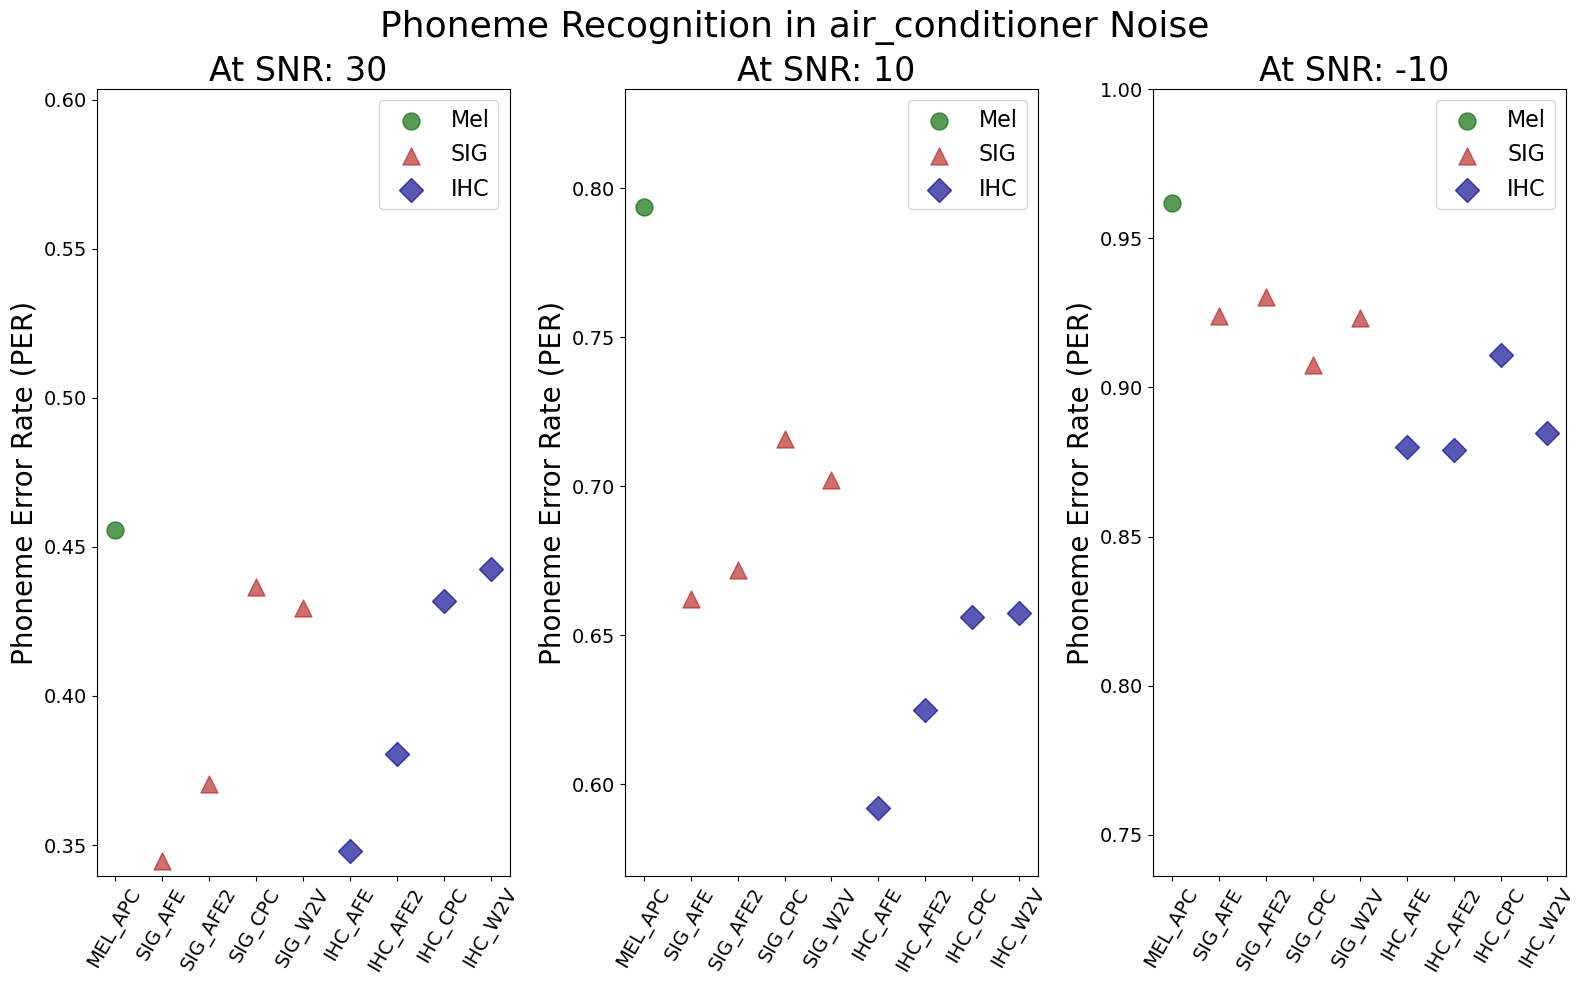

In [121]:
noise="White"
noise="air_conditioner"
#noise="dog_bark"
#noise="street_music"
#noise="children_playing"

IHC_noise_PER(noise)

0.1646670586867571
0.1646670586867571
0.1646670586867571


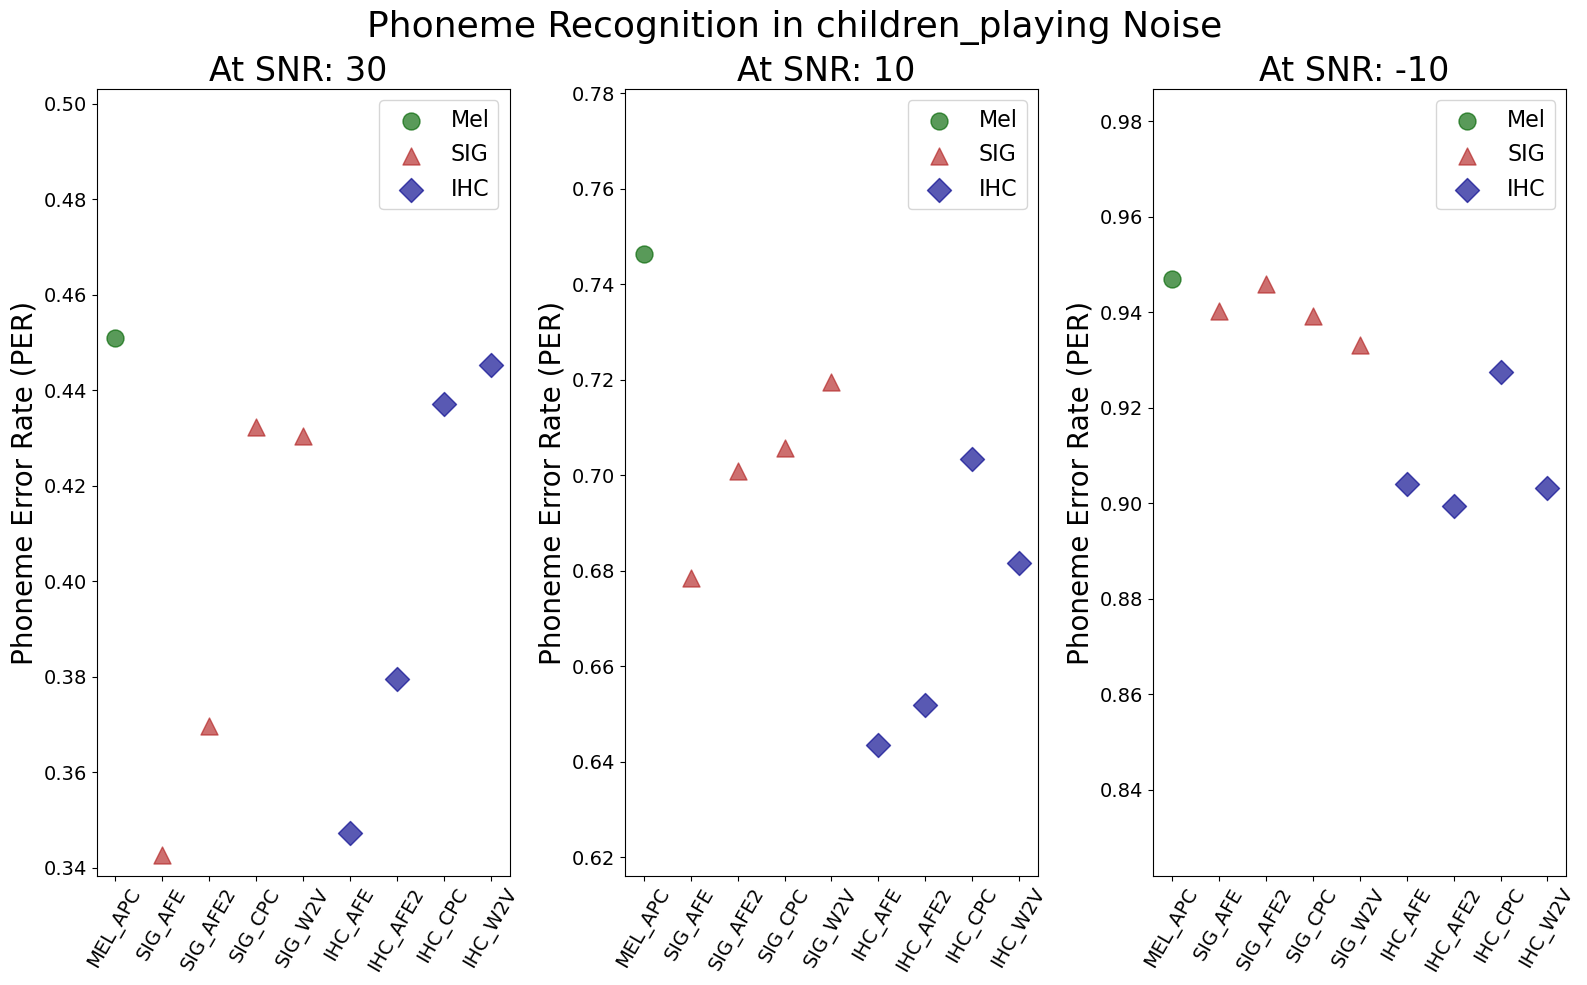

In [85]:
#noise="White"
#noise="air_conditioner"
#noise="dog_bark"
#noise="street_music"
noise="children_playing"

IHC_noise_PER(noise)

## When do IHCs start to outperform signal-based and Mel models?


In [ ]:
def model_noise_reaction(noise, model="AFE2"):
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()
    ########################
    for type in model_input:
        #Get all the snrs that were tested 
        for snr in SNRs:
            with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                loaded_test = pickle.load(f)

            #Split the dataframe into Model and kFold
            df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
            df=df.reset_index()
            df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
            if type=="original":
                df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
            elif type=="IHC":
                df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
            df["Model Type"]=df["Model"].apply(model_check)
            df.drop(columns=["index"], inplace=True)
            df['SNR']=snr
            df['Noise Type']=noise
            df["PER"]=1-df["Accuracy"]
            df["Designation"]=df["Model"].apply(lambda x: designations[x])
            df.reset_index()
    
            #Concatenate this loaded test to other dataframes
            noisy_df=pd.concat([noisy_df, df], ignore_index=True)
    ###################################
    #Get the range of different model performance for each designation
    models=noisy_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Designation", "SNR", "Model Type"]].groupby(["Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Designation", "SNR", "Input Type"]].groupby(["Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    fig, (ax)=plt.subplots(figsize=(12, 7))

    types=noisy_df["Model Type"].unique()
    order=['APC', 'CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large',
       'AFE2']
    
    mean_PER=mean_PER[mean_PER["Model Type"]==model]
    models=mean_PER["Designation"].unique()
    
    for m in models:
        sub_PER=mean_PER[mean_PER["Designation"]==m]
        input=sub_PER["Input Type"].iloc[0]
        sub_PER= sub_PER.sort_values("SNR", ascending=False)
        
        ax.plot(sub_PER["SNR"], sub_PER["PER"], color=line_colour[input], label=labels[input])
        ax.fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.5)
        ax.set_ylim(0.3, 1)
        ax.legend(fontsize=16)
        #ax.set_title("%s Model in Noise %s " %(type))
        #ax.invert_xaxis()

    plt.ylabel("Phoneme Error Rate (PER)", fontsize=20)
    plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)

    fig.suptitle("{}'s PER in {} Noise, with k-Fold Testing".format(model, noise), fontsize=24)

    fig.tight_layout()

In [ ]:
#noise="White"
noise="air_conditioner"
#noise="dog_bark"
#noise="street_music"
noise="children_playing"

model_noise_reaction(noise)

## Is this response independent of noise type?
We will look at the response of our best performing model, as this is independent of model type.

In [26]:
noise_dict={"White": "White", "air_conditioner":"Air Conditioner", "dog_bark":"Dog Bark", "children_playing":"Children Playing", "street_music": "Street Music"}
noise_types=["White", "air_conditioner", "dog_bark", "children_playing", "street_music"]

In [27]:
def best_performing():
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()
    
    for noise in noise_types:
    ########################
        for type in model_input:
            #Get all the snrs that were tested 
            for snr in SNRs:
                with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                    loaded_test = pickle.load(f)

                #Split the dataframe into Model and kFold
                df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
                df=df.reset_index()
                df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
                if type=="original":
                    df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
                elif type=="IHC":
                    df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
                df["Model Type"]=df["Model"].apply(model_check)
                df.drop(columns=["index"], inplace=True)
                df['SNR']=snr
                df['Noise Type']=noise_dict[noise]
                df["PER"]=1-df["Accuracy"]
                df["Designation"]=df["Model"].apply(lambda x: designations[x])
                df.reset_index()
    
                #Concatenate this loaded test to other dataframes
                noisy_df=pd.concat([noisy_df, df], ignore_index=True)
    ###################################
    #Get the range of different model performance for each designation
    models=noisy_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Designation", "Noise Type","SNR", "Model Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Designation","Noise Type", "SNR", "Input Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    #fig, (ax)=plt.subplots(figsize=(12, 7))

    types=noisy_df["Designation"].unique()
    noisys=noisy_df["Noise Type"].unique()
    order=['APC', 'CPC', 'W2V', 'AFE', 'AFE2']

    table_list=[]
    
    
    for model in types:
        table_row={}
        table_row["Designation"]=model
        table_row["Total"]=0
        table_row["Range"]=0
        table_row["std"]=0
        
        
        for noise in noisys:
            for snr in SNRs:
                table_row["Total"]=mean_PER[(mean_PER['Designation'] ==model) & (mean_PER['Noise Type'] ==noise) & (mean_PER["SNR"]== snr)]["PER"].iloc[0]+table_row["Total"]
                table_row["Range"]=mean_PER[(mean_PER['Designation'] ==model) & (mean_PER['Noise Type'] ==noise) & (mean_PER["SNR"]== snr)]["Upper Range"].iloc[0]\
                -mean_PER[(mean_PER['Designation'] ==model)& (mean_PER['Noise Type'] ==noise)  & (mean_PER["SNR"]== snr)]["Lower Range"].iloc[0]+table_row["Range"]
                table_row["std"]=mean_PER[(mean_PER['Designation'] ==model)& (mean_PER['Noise Type'] ==noise)  & (mean_PER["SNR"]== snr)]["std"].iloc[0]+table_row["std"]

        table_row["Avg PER"]=table_row["Total"]/len(SNRs)/len(noisys)
        table_row["Avg Range"]=table_row["Range"]/len(SNRs)/len(noisys)
        table_row["Avg STD"]=table_row["std"]/len(SNRs)/len(noisys)
        #print(table_row)
        table_list.append(table_row)


    table=pd.DataFrame(table_list)
    table=table.drop(columns=["Total", "Range", "std"])
    table.sort_values(by="Avg PER", ascending=True, inplace=True)
    table["Avg PER"]=table["Avg PER"].apply(lambda x: "%0.2f" %(x*100))
    table["Avg Range"]=table["Avg Range"].apply(lambda x: "%0.2f" %(x*100))
    table["Avg STD"]=table["Avg STD"].apply(lambda x: "%0.2f" %(x*100))
    print(table)
        

In [28]:
best_performing()

      Designation Avg PER Avg Range Avg STD
15       IHC_AFE2   63.04      2.76    1.11
13        IHC_AFE   63.12      4.71    1.95
14  IHC_AFE_large   64.22      2.11    0.84
6         SIG_AFE   65.50      3.25    1.40
11  IHC_W2V_small   65.69      1.49    0.59
7   SIG_AFE_large   65.79      1.66    0.68
12        IHC_W2V   66.42      4.51    1.91
8        SIG_AFE2   66.87      2.39    1.00
10  IHC_CPC_small   68.17      1.37    0.53
9         IHC_CPC   68.69      1.19    0.49
3   SIG_W2V_small   68.81      1.18    0.46
4   SIG_CPC_small   69.15      1.47    0.61
2         SIG_W2V   69.43      1.47    0.60
5         SIG_CPC   69.94      1.76    0.73
0         MEL_APC   72.86      1.49    0.60
1   MEL_APC_small   76.62      0.40    0.16


In [ ]:
def best_performing_bars():
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()
    
    for noise in noise_types:
    ########################
        for type in model_input:
            #Get all the snrs that were tested 
            for snr in SNRs:
                with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                    loaded_test = pickle.load(f)

                #Split the dataframe into Model and kFold
                df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
                df=df.reset_index()
                df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
                if type=="original":
                    df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
                elif type=="IHC":
                    df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
                df["Model Type"]=df["Model"].apply(model_check)
                df.drop(columns=["index"], inplace=True)
                df['SNR']=snr
                df['Noise Type']=noise_dict[noise]
                df["PER"]=1-df["Accuracy"]
                df["Designation"]=df["Model"].apply(lambda x: designations[x])
                df.reset_index()
    
                #Concatenate this loaded test to other dataframes
                noisy_df=pd.concat([noisy_df, df], ignore_index=True)
    ###################################
    #Get the range of different model performance for each designation
    models=noisy_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Designation", "Noise Type","SNR", "Model Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Designation","Noise Type", "SNR", "Input Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    #fig, (ax)=plt.subplots(figsize=(12, 7))

    types=noisy_df["Designation"].unique()
    noisys=noisy_df["Noise Type"].unique()
    order=['APC', 'CPC', 'W2V', 'AFE', 'AFE2']

    table_list=[]
    
    for noise in noisys:
        
            for model in types:
            for snr in SNRs:
                table_row["Total"]=mean_PER[(mean_PER['Designation'] ==model) & (mean_PER['Noise Type'] ==noise) & (mean_PER["SNR"]== snr)]["PER"].iloc[0]+table_row["Total"]
                table_row["Range"]=mean_PER[(mean_PER['Designation'] ==model) & (mean_PER['Noise Type'] ==noise) & (mean_PER["SNR"]== snr)]["Upper Range"].iloc[0]\
                -mean_PER[(mean_PER['Designation'] ==model)& (mean_PER['Noise Type'] ==noise)  & (mean_PER["SNR"]== snr)]["Lower Range"].iloc[0]+table_row["Range"]
                table_row["std"]=mean_PER[(mean_PER['Designation'] ==model)& (mean_PER['Noise Type'] ==noise)  & (mean_PER["SNR"]== snr)]["std"].iloc[0]+table_row["std"]

        table_row["Avg PER"]=table_row["Total"]/len(SNRs)/len(noisys)
        table_row["Avg Range"]=table_row["Range"]/len(SNRs)/len(noisys)
        table_row["Avg STD"]=table_row["std"]/len(SNRs)/len(noisys)
        #print(table_row)
        table_list.append(table_row)


    table=pd.DataFrame(table_list)
    table=table.drop(columns=["Total", "Range", "std"])
    table.sort_values(by="Avg PER", ascending=True, inplace=True)
    table["Avg PER"]=table["Avg PER"].apply(lambda x: "%0.2f" %(x*100))
    table["Avg Range"]=table["Avg Range"].apply(lambda x: "%0.2f" %(x*100))
    table["Avg STD"]=table["Avg STD"].apply(lambda x: "%0.2f" %(x*100))
    print(table)

In [29]:
def noise_reaction(model="AFE2"):
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()
    for noise in noise_types:
    ########################
        for type in model_input:
            #Get all the snrs that were tested 
            for snr in SNRs:
                with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                    loaded_test = pickle.load(f)

                #Split the dataframe into Model and kFold
                df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
                df=df.reset_index()
                df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
                if type=="original":
                    df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
                elif type=="IHC":
                    df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
                df["Model Type"]=df["Model"].apply(model_check)
                df.drop(columns=["index"], inplace=True)
                df['SNR']=snr
                df['Noise Type']=noise_dict[noise]
                df["PER"]=1-df["Accuracy"]
                df["Designation"]=df["Model"].apply(lambda x: designations[x])
                df.reset_index()
    
                #Concatenate this loaded test to other dataframes
                noisy_df=pd.concat([noisy_df, df], ignore_index=True)
    ###################################
    #Get the range of different model performance for each designation
    models=noisy_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Designation", "Noise Type","SNR", "Model Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Designation","Noise Type", "SNR", "Input Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    #fig, (ax)=plt.subplots(figsize=(12, 7))

    types=noisy_df["Model Type"].unique()
    order=['APC', 'CPC', 'W2V', 'AFE', 'AFE2']
    
    mean_PER=mean_PER[mean_PER["Designation"]!="MEL_APC_small"]

    mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER["PER"]=mean_PER["PER"].apply(lambda x:  "%0.2f" %(x*100))
    mean_PER["PER"]=pd.to_numeric(mean_PER["PER"])
    mean_PER["Model Type"]=mean_PER["Model Type"].astype("category").cat.reorder_categories(order)
    
    mean_PER=mean_PER[mean_PER["Model Type"]==model]
    mean_PER["SNR"]=mean_PER["SNR"].astype(int)
    mean_PER=mean_PER.sort_values(by="SNR", ascending=False)
    latex_PER=mean_PER.pivot(index=["Noise Type", "Input Type",], columns="SNR", values="PER")
    latex_PER=latex_PER.reindex([30, 25, 20, 15, 10, 5, 0, -5, -10], axis=1)
    print(latex_PER.to_latex())

    show_mean=mean_PER[mean_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="PER").mean()-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    #show_mean=show_mean.sort_values(ascending=False)
    show_third=mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="Upper Range").mean()*100-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    show_first=mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="Lower Range").mean()*100-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    show_IHC_third=mean_PER[mean_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="Upper Range").mean()*100-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    show_IHC_first=mean_PER[mean_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="Lower Range").mean()*100-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    print(show_IHC_third)
    print(show_IHC_first)
    
    colours=[]
    for val in show_mean:
        if(val)> 0:
            colours.append("firebrick")
        else:
            colours.append("#a1d99b")
    
    fig, (ax)=plt.subplots(nrows=4, figsize=(12, 7))

    
    show_third.plot.bar(color="#bdbdbd", width=0.65,  hatch="/", alpha=0.4)
    show_first.plot.bar(color="#bdbdbd", width=0.65,  hatch="/", alpha=0.4, label="SIG Average Range")
    #show_IHC_third.plot.bar(color="#fee6ce", width=0.6,   alpha=0.9)
    #show_IHC_first.plot.bar(color="#fee6ce", width=0.6,   alpha=0.9, label="IHC Range")
    show_mean.plot.bar(color=colours, ax=ax, label="IHC Average Improvement", alpha=0.9)
    ax.invert_xaxis()
    ax.set_ylabel("PER % Change", fontsize=18)
    ax.set_xlabel("Signal-to-Noise Ratio (SNR)", fontsize=18)
    ax.legend(fontsize=16)
    fig.suptitle("Effect of using IHCs over SIG on PER, averaged across Noise Type", fontsize=20)
    fig.tight_layout()
    fig.show()

\begin{tabular}{llrrrrrrrrr}
\toprule
 & SNR & 30 & 25 & 20 & 15 & 10 & 5 & 0 & -5 & -10 \\
Noise Type & Input Type &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Air Conditioner} & IHC & 38.070000 & 40.420000 & 44.930000 & 52.930000 & 62.510000 & 71.100000 & 78.150000 & 83.730000 & 87.910000 \\
 & SIG & 37.030000 & 39.320000 & 44.600000 & 54.650000 & 67.200000 & 78.270000 & 85.730000 & 90.220000 & 93.040000 \\
\cline{1-11}
\multirow[t]{2}{*}{Children Playing} & IHC & 37.960000 & 40.390000 & 45.800000 & 54.760000 & 65.190000 & 74.200000 & 81.370000 & 86.540000 & 89.950000 \\
 & SIG & 36.960000 & 39.610000 & 46.440000 & 58.080000 & 70.080000 & 79.810000 & 86.960000 & 91.740000 & 94.600000 \\
\cline{1-11}
\multirow[t]{2}{*}{Dog Bark} & IHC & 37.530000 & 39.090000 & 41.920000 & 46.520000 & 52.760000 & 59.580000 & 66.310000 & 72.690000 & 78.420000 \\
 & SIG & 36.690000 & 38.560000 & 42.350000 & 48.820000 & 56.830000 & 64.900000 & 72.030000 & 77.980000 & 83.070000 \\
\cline{1-11}

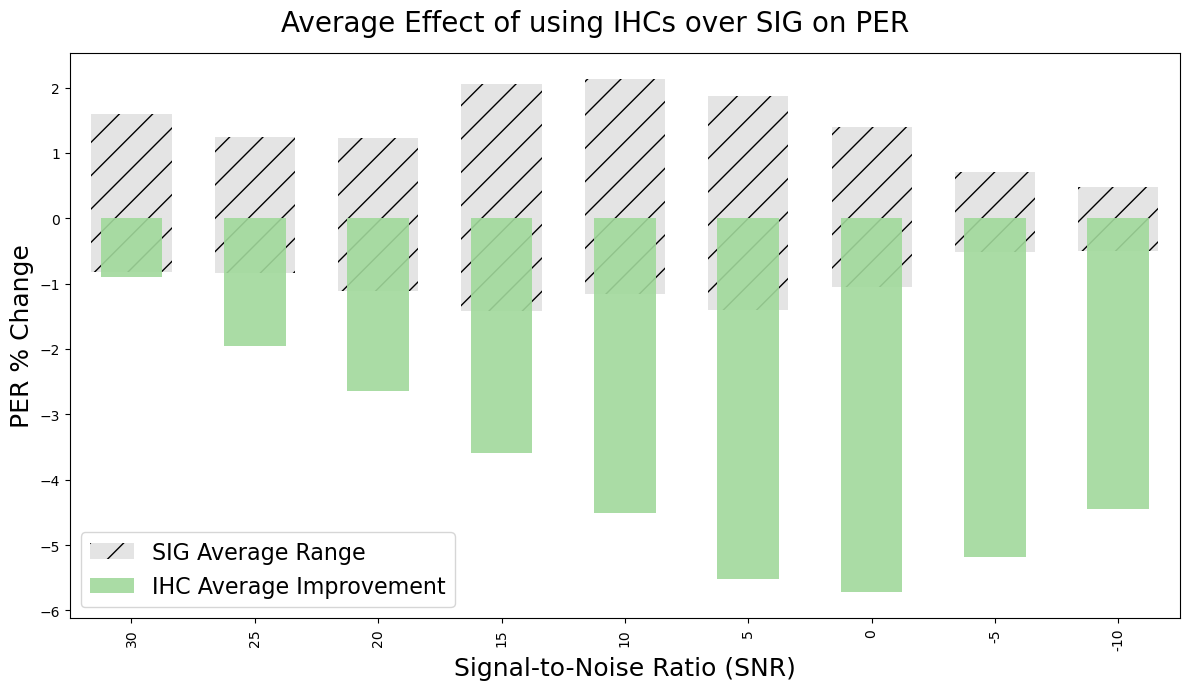

In [30]:
noise_reaction()

\begin{tabular}{llrrrrrrrrr}
\toprule
 & SNR & 30 & 25 & 20 & 15 & 10 & 5 & 0 & -5 & -10 \\
Noise Type & Input Type &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Air Conditioner} & IHC & 34.790000 & 36.910000 & 41.210000 & 48.910000 & 59.220000 & 69.520000 & 78.120000 & 83.970000 & 87.990000 \\
 & SIG & 34.460000 & 36.860000 & 42.210000 & 52.260000 & 66.230000 & 78.410000 & 86.450000 & 90.550000 & 92.400000 \\
\cline{1-11}
\multirow[t]{2}{*}{Children Playing} & IHC & 34.730000 & 37.200000 & 42.830000 & 52.770000 & 64.360000 & 74.960000 & 82.670000 & 87.490000 & 90.420000 \\
 & SIG & 34.280000 & 36.770000 & 43.120000 & 54.680000 & 67.860000 & 78.810000 & 86.720000 & 91.440000 & 94.020000 \\
\cline{1-11}
\multirow[t]{2}{*}{Dog Bark} & IHC & 34.390000 & 36.170000 & 39.420000 & 44.520000 & 51.450000 & 59.280000 & 66.620000 & 73.170000 & 78.940000 \\
 & SIG & 34.290000 & 36.380000 & 40.820000 & 47.800000 & 56.420000 & 65.310000 & 72.890000 & 78.620000 & 83.130000 \\
\cline{1-11}

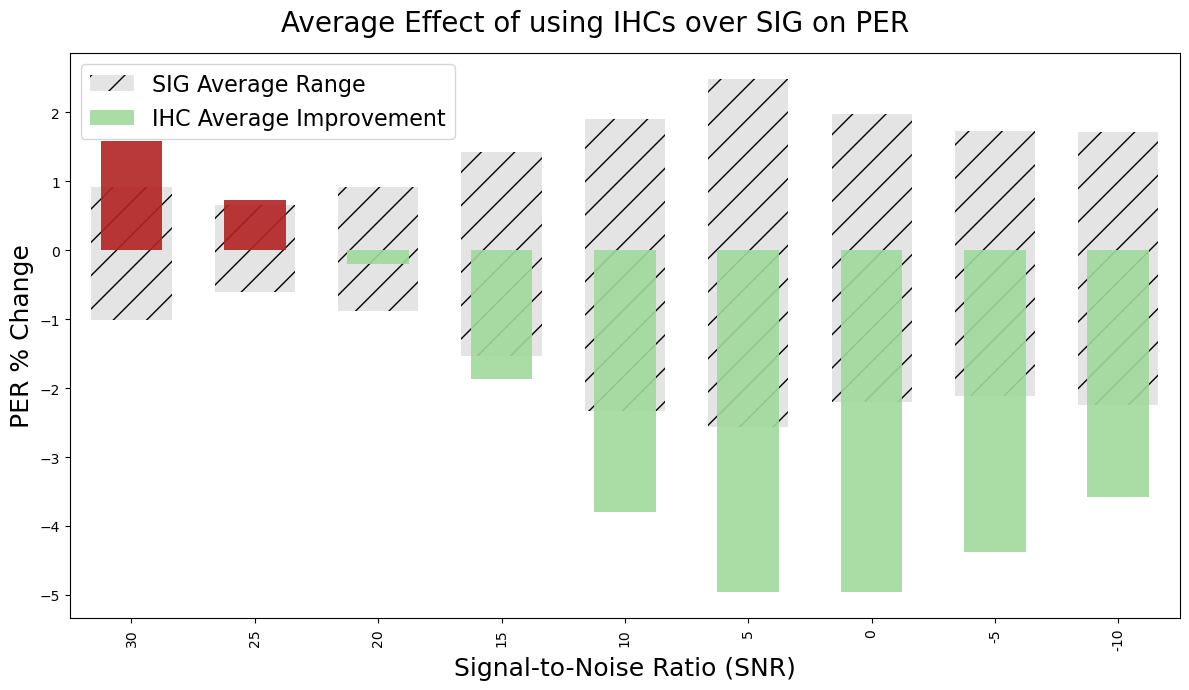

In [31]:
noise_reaction("AFE")

In [82]:
def noise_reaction_across_models():
    #Get the original models and IHC models in one dataframe
    model_input=["original", "IHC"] 
    noisy_df=pd.DataFrame()
    for noise in noise_types:
    ########################
        for type in model_input:
            #Get all the snrs that were tested 
            for snr in SNRs:
                with open('Results/Noisy/k-Fold Stability/{}/{}/{}_models.pkl'.format(noise, snr, type), 'rb') as f:
                    loaded_test = pickle.load(f)

                #Split the dataframe into Model and kFold
                df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
                df=df.reset_index()
                df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
                if type=="original":
                    df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG" )
                elif type=="IHC":
                    df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
                df["Model Type"]=df["Model"].apply(model_check)
                df.drop(columns=["index"], inplace=True)
                df['SNR']=snr
                df['Noise Type']=noise_dict[noise]
                df["PER"]=1-df["Accuracy"]
                df["Designation"]=df["Model"].apply(lambda x: designations[x])
                df.reset_index()
    
                #Concatenate this loaded test to other dataframes
                noisy_df=pd.concat([noisy_df, df], ignore_index=True)
    ###################################
    #Get the range of different model performance for each designation
    models=noisy_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=noisy_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=noisy_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=noisy_df[["Designation", "Noise Type","SNR", "Model Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=noisy_df[["Designation","Noise Type", "SNR", "Input Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    #fig, (ax)=plt.subplots(figsize=(12, 7))

    types=noisy_df["Model Type"].unique()
    order=[ 'CPC', 'W2V', 'AFE', 'AFE2']
    
    mean_PER=mean_PER[mean_PER["Designation"]!="MEL_APC_small"]

    mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER["PER"]=mean_PER["PER"].apply(lambda x:  "%0.2f" %(x*100))
    mean_PER["PER"]=pd.to_numeric(mean_PER["PER"])
    mean_PER["Model Type"]=mean_PER["Model Type"].astype("category").cat.reorder_categories(order)

    fig, (ax)=plt.subplots(nrows=4, figsize=(12, 14))

   
    for model in order:
        sub_PER=mean_PER[mean_PER["Model Type"]==model]
        sub_PER["SNR"]=sub_PER["SNR"].astype(int)
        sub_PER=sub_PER.sort_values(by="SNR", ascending=False)
        latex_PER=sub_PER.pivot(index=["Noise Type", "Input Type",], columns="SNR", values="PER")
        latex_PER=latex_PER.reindex([30, 25, 20, 15, 10, 5, 0, -5, -10], axis=1)
        #print(latex_PER.to_latex())
        
        show_mean=sub_PER[sub_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="PER").mean()-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
        #show_mean=show_mean.sort_values(ascending=False)
        show_third=sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="Upper Range").mean()*100-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
        show_first=sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="Lower Range").mean()*100-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
        show_IHC_third=sub_PER[sub_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="Upper Range").mean()*100-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
        show_IHC_first=sub_PER[sub_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="Lower Range").mean()*100-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
        print(show_IHC_third)
        print(show_IHC_first)
        print(show_mean)
        
        colours=[]
        for val in show_mean:
            if(val)> 0:
                colours.append("firebrick")
            else:
                colours.append("#a1d99b")
    
        show_third.plot.bar(color="#bdbdbd", width=0.65,  hatch="/", alpha=0.4)
        show_first.plot.bar(color="#bdbdbd", width=0.65,  hatch="/", alpha=0.4, label="SIG Average Range")
    #show_IHC_third.plot.bar(color="#fee6ce", width=0.6,   alpha=0.9)
    #show_IHC_first.plot.bar(color="#fee6ce", width=0.6,   alpha=0.9, label="IHC Range")
        print(colours)
        show_mean.plot.bar(color=colours, ax=ax, label="IHC Average Improvement", alpha=0.9)

        ax.invert_xaxis()
        ax.set_ylabel("PER % Change", fontsize=18)
        #ax.set_xlabel("Signal-to-Noise Ratio (SNR)", fontsize=18)
        ax.legend(fontsize=16)
        ax.set_title("{}".format(model), fontsize=20)


    fig.suptitle("Effect of using IHCs over SIG on PER, averaged across Noise Type", fontsize=20)
    fig.tight_layout()
    fig.show()

SNR
-10   -1.182566
-5    -2.306943
 0    -3.216179
 5    -3.239779
 10   -2.027751
 15   -0.080320
 20    1.100108
 25    1.359575
 30    3.298962
dtype: float64
SNR
-10   -2.366667
-5    -3.777048
 0    -4.863736
 5    -4.673411
 10   -3.150679
 15   -1.144241
 20    0.082193
 25    0.543091
 30    2.311814
dtype: float64
SNR
-10   -1.612
-5    -2.864
 0    -3.844
 5    -3.798
 10   -2.546
 15   -0.676
 20    0.424
 25    0.866
 30    2.796
dtype: float64
['#a1d99b', '#a1d99b', '#a1d99b', '#a1d99b', '#a1d99b', '#a1d99b', 'firebrick', 'firebrick', 'firebrick']


/tmp/ipykernel_3415833/2000577985.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_PER["SNR"]=sub_PER["SNR"].astype(int)


AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'

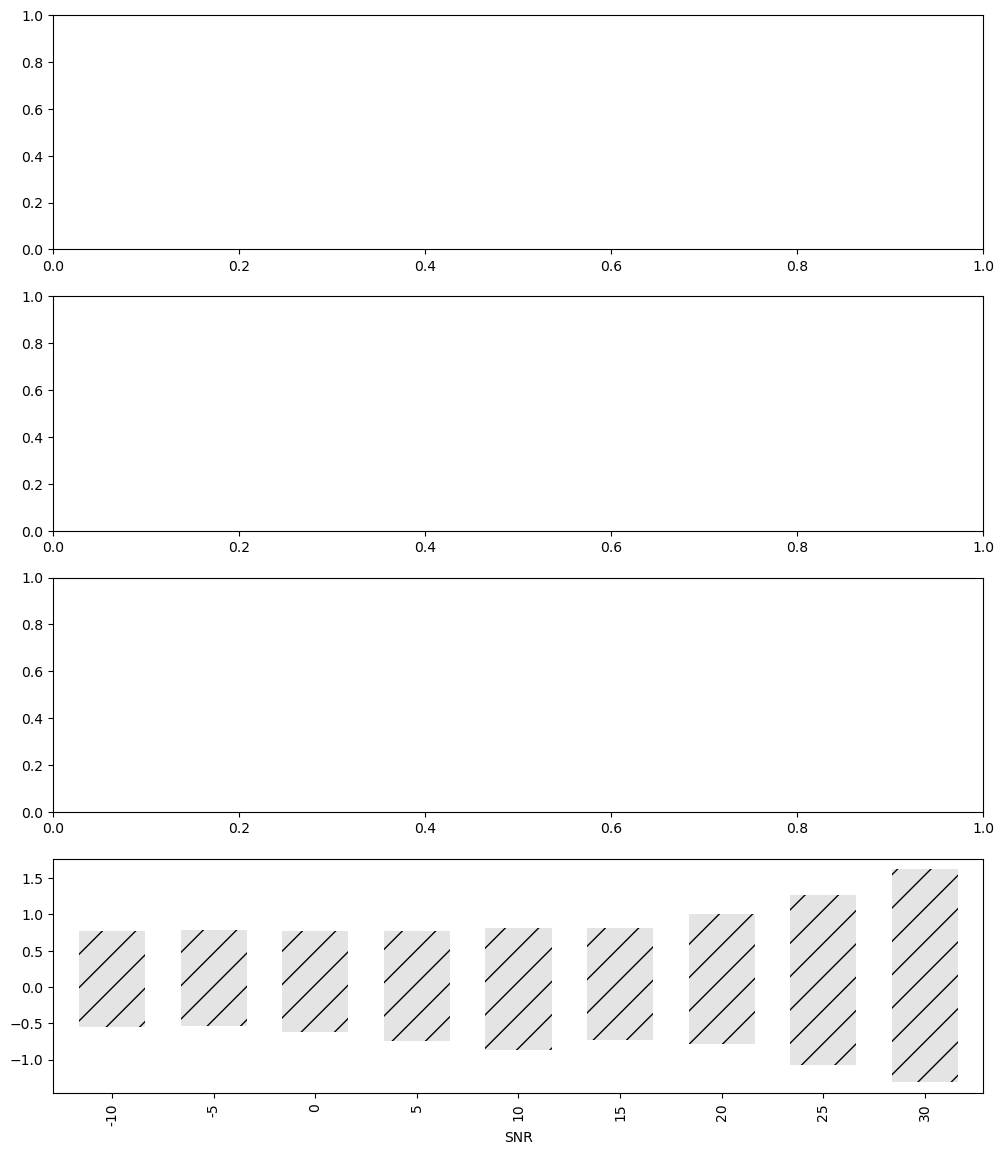

In [83]:
noise_reaction_across_models()

In [122]:
                      noisy_df=pd.DataFrame()

for snr in SNRs:
    with open('Results/Noisy/k-Fold Stability/{}/{}/original_models.pkl'.format(snr), 'rb') as f:
        loaded_test = pickle.load(f)

    #Split the dataframe into Model and kFold
    df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
    df=df.reset_index()
    df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
    df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG")
    df["Model Type"]=df["Model"].apply(model_check)
    df.drop(columns=["index"], inplace=True)
    df['SNR']=snr
    df['Noise Type']='White'
    df["PER"]=1-df["Accuracy"]
    df["Designation"]=df["Model"].apply(lambda x: designations[x])
    df.reset_index()
    
    #Concatenate to other dataframes
    noisy_df=pd.concat([noisy_df, df], ignore_index=True)

noisy_df

IndexError: Replacement index 1 out of range for positional args tuple

In [123]:
for snr in SNRs:
    with open('Results/Noisy/k-Fold Stability/White/{}/IHC_models.pkl'.format(snr), 'rb') as f:
        loaded_test = pickle.load(f)

    #Split the dataframe into Model and kFold
    df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
    df=df.reset_index()
    df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
    df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
    df["Model Type"]=df["Model"].apply(model_check)
    df.drop(columns=["index"], inplace=True)
    df['SNR']=snr
    df['Noise Type']='White'
    df["PER"]=1-df["Accuracy"]
    df["Designation"]=df["Model"].apply(lambda x: designations[x])
    df.reset_index()
    
    #Concatenate to other dataframes
    noisy_df=pd.concat([noisy_df, df], ignore_index=True)

noisy_df

KeyError: 'IHC_Extract_3.0'

In [ ]:
models=noisy_df['Designation'].unique()

mean_PER=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
mean_PER["Upper Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
mean_PER["Lower Range"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0)["PER"]
mean_PER["Third Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.75)["PER"]
mean_PER["First Quartile"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.25)["PER"]
mean_PER["std"]=noisy_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).std()["PER"]
mean_PER["Model Type"]=noisy_df[["Designation", "SNR", "Model Type"]].groupby(["Designation", "SNR"]).first()["Model Type"]
mean_PER["Input Type"]=noisy_df[["Designation", "SNR", "Input Type"]].groupby(["Designation", "SNR"]).first()["Input Type"]

mean_PER=mean_PER.reset_index()

mean_PER

NameError: name 'mean_PER' is not defined

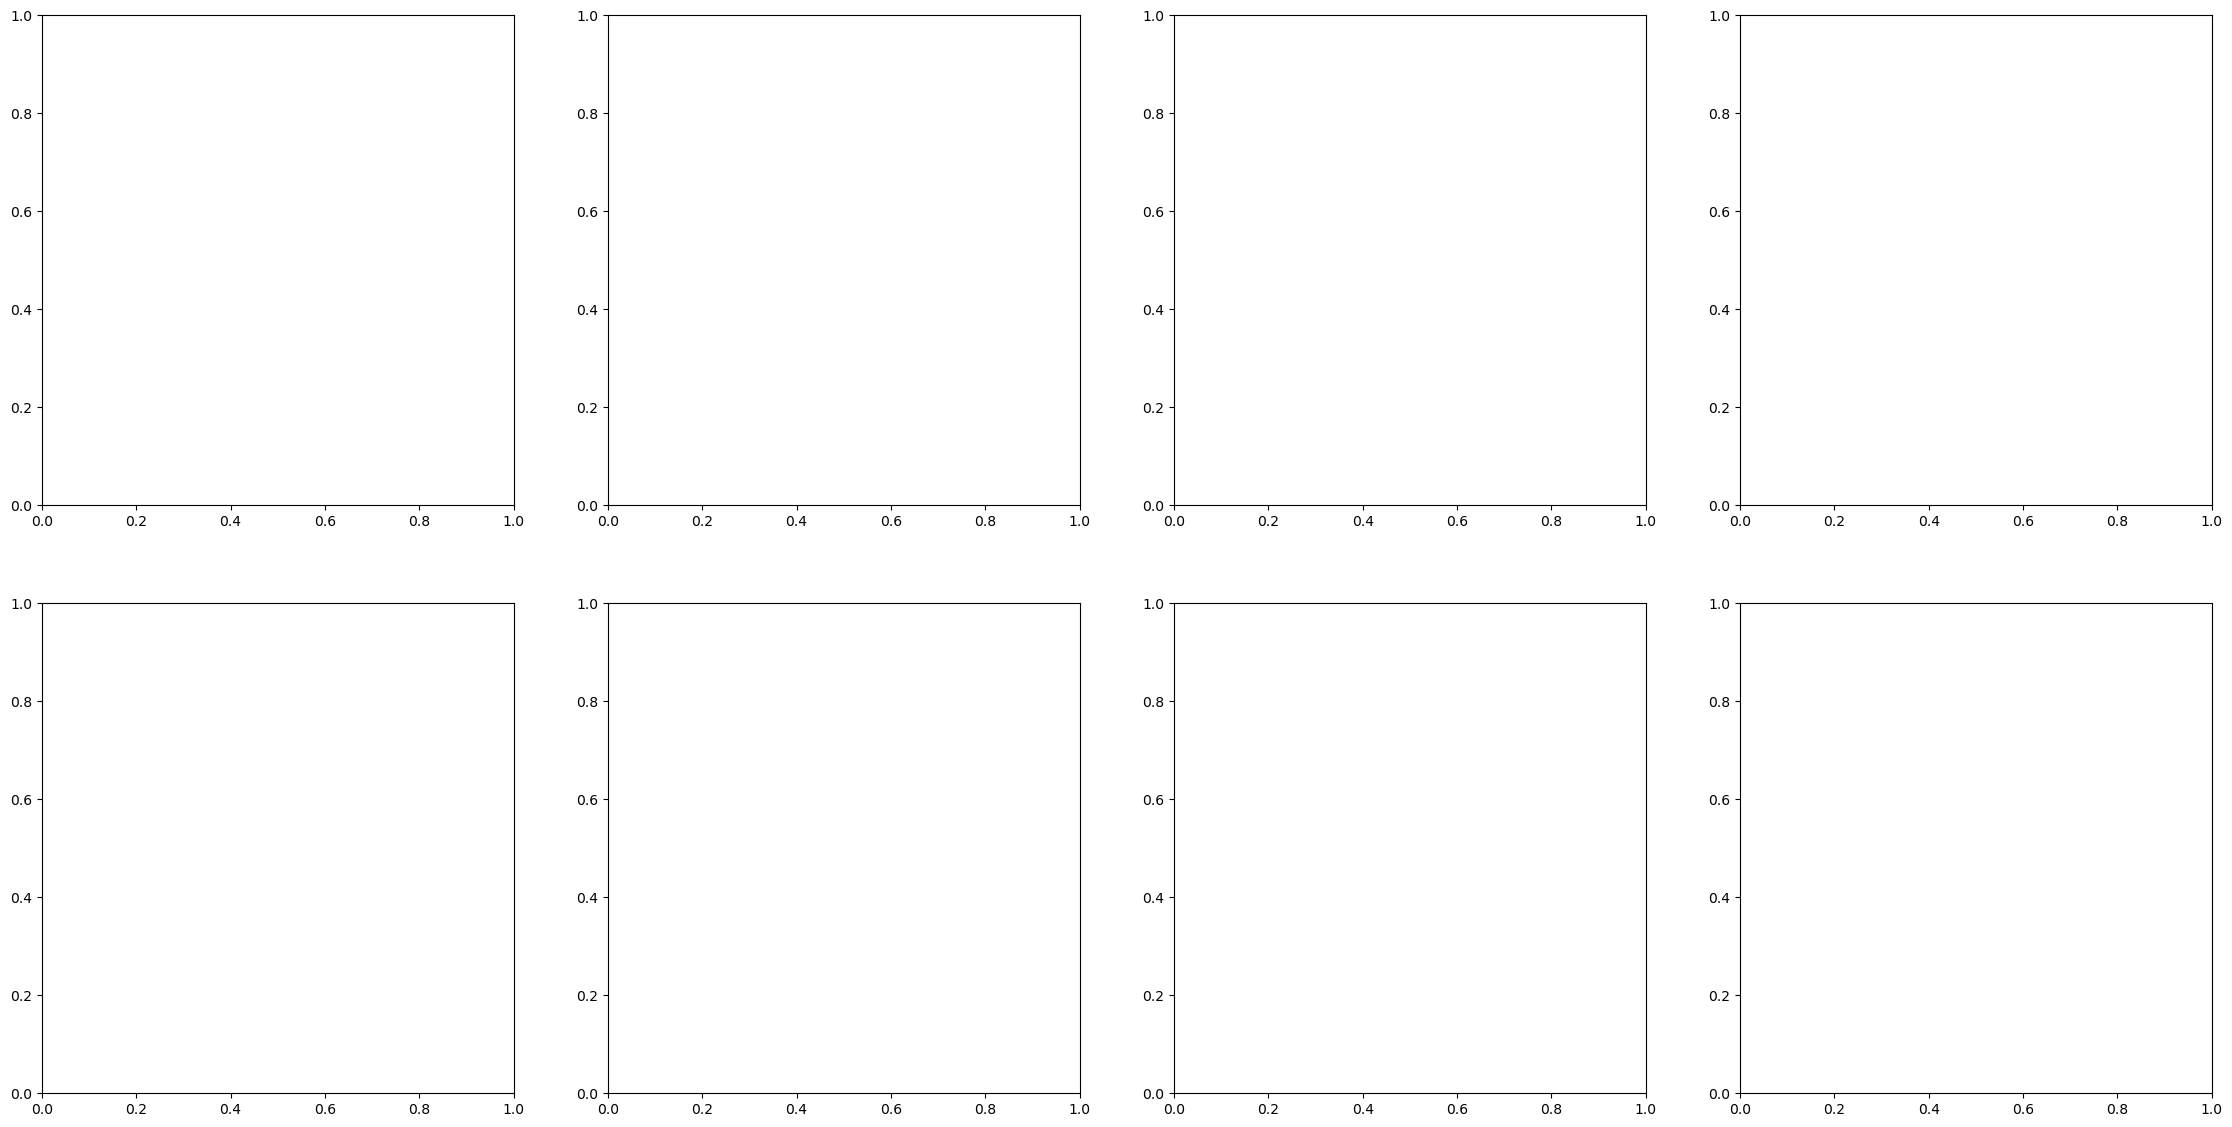

In [124]:
#models=["SIG_W2V", "MEL_APC", "IHC_AFE", "IHC_AFE2"]
line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
#colours={"SIG_W2V": "#fc8d62", "MEL_APC": "#66c2a5", "IHC_AFE": "#8da0cb", "IHC_AFE2": "lightblue"}
labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

fig, (ax)=plt.subplots(nrows=2, ncols=4, figsize=(28, 14))

types=combined_models["Model Type"].unique()

order=['APC', 'CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large',
       'AFE2']


for ii, type in enumerate(order):
    subset=mean_PER[mean_PER["Model Type"]==type]

    models=subset["Designation"].unique()

    j=ii%4
    i=(ii//4)
 
    for model in models:
        
        sub_PER=subset[subset["Designation"]==model]
        input=sub_PER["Input Type"].iloc[0]
        sub_PER= sub_PER.sort_values("SNR", ascending=True)
        
        ax[i, j].plot(sub_PER["SNR"], sub_PER["PER"], color=line_colour[input], label=labels[input])
        ax[i, j].fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.5)
        ax[i, j].set_ylim(0.3, 1)
        ax[i, j].legend(fontsize=16)
        ax[i, j].set_title("%s Model " %type)
        ax[i, j].invert_xaxis()



plt.ylabel("Phoneme Error Rate (PER)", fontsize=20)
plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)

fig.suptitle("Phoneme Recognition in White Noise, k-Fold Testing", fontsize=24)

fig.tight_layout()

NameError: name 'mean_PER' is not defined

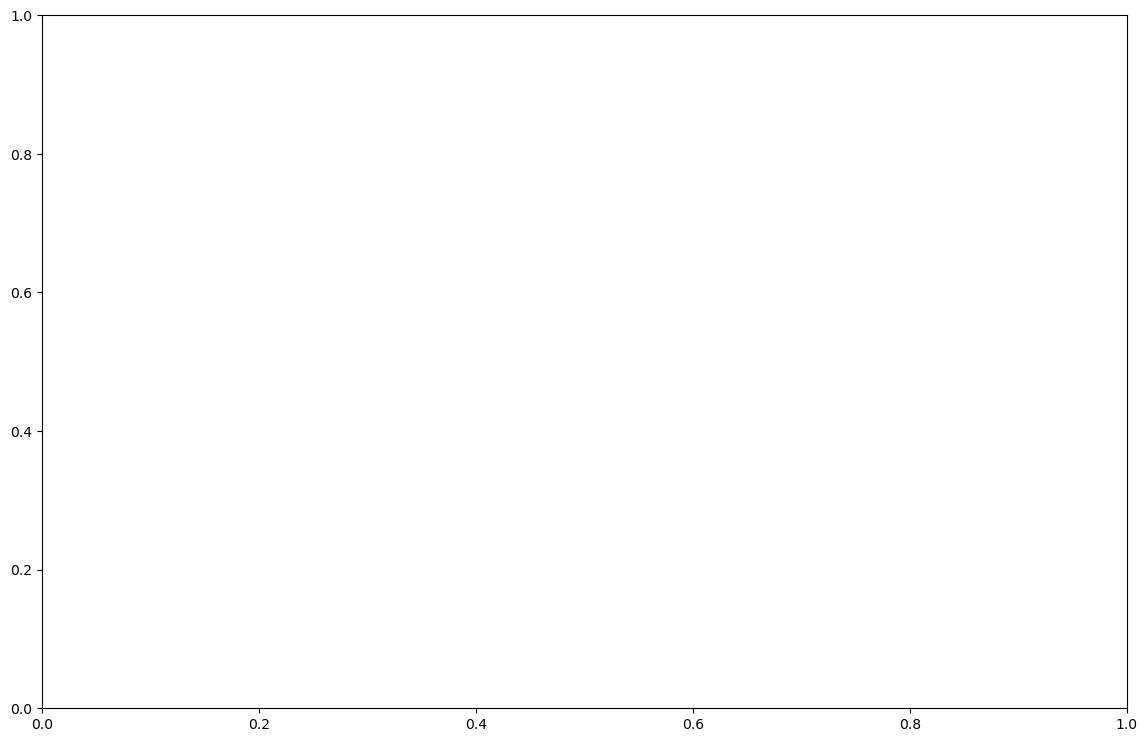

In [125]:
#models=["SIG_W2V", "MEL_APC", "IHC_AFE", "IHC_AFE2"]
line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
#colours={"SIG_W2V": "#fc8d62", "MEL_APC": "#66c2a5", "IHC_AFE": "#8da0cb", "IHC_AFE2": "lightblue"}
labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

fig, (ax)=plt.subplots( figsize=(14, 9))

types=combined_models["Model Type"].unique()

order=['APC', 'CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large',
       'AFE2']


subset=mean_PER[mean_PER["Model Type"]=='AFE2']

models=subset["Designation"].unique()
 
for model in models:
        
    sub_PER=subset[subset["Designation"]==model]
    input=sub_PER["Input Type"].iloc[0]
    sub_PER= sub_PER.sort_values("SNR", ascending=True)
        
    ax.plot(sub_PER["SNR"], sub_PER["PER"], color=line_colour[input], label=labels[input])
    ax.fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.5)
    ax.set_ylim(0.3, 1)
    ax.legend(fontsize=16)
    ax.set_title("Best Performing Model: AFE2", fontsize=26)
    
ax.invert_xaxis()



plt.ylabel("Phoneme Error Rate (PER)", fontsize=20)
plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)

fig.suptitle("Phoneme Recognition in White Noise, k-Fold Testing", fontsize=24)

fig.tight_layout()

Results
Impact of using IHCs on Clean Speech
Impact of using IHCs on Noisy Speech
Impact of Model Size
Impact of Noise Type


In [126]:
models=mean_PER["Designation"].unique()

line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
#colours={"SIG_W2V": "#fc8d62", "MEL_APC": "#66c2a5", "IHC_AFE": "#8da0cb", "IHC_AFE2": "lightblue"}
labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

fig, (ax)=plt.subplots(figsize=(16, 9))

types=combined_models["Model Type"].unique()

order=['MEL', 'CPC', 'CPC_small', 'W2V', 'W2V_small', 'AFE', 'AFE_large',
       'AFE2']
 
for model in models:
        sub_PER=mean_PER[mean_PER["Designation"]==model]
        input=sub_PER["Input Type"].iloc[0]
        sub_PER= sub_PER.sort_values("SNR", ascending=True)
        
        ax.plot(sub_PER["SNR"], sub_PER["PER"], color=line_colour[input], label=labels[input], alpha=0.3)
        ax.fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.2)
        ax.set_ylim(0.3, 1)
        #ax[i, j].set_title("%s Model " %type)
        ax.invert_xaxis()


ax.legend(fontsize=16)
plt.ylabel("Phoneme Error Rate (PER)", fontsize=20)
plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)

fig.suptitle("Phoneme Recognition in White Noise", fontsize=24)

fig.tight_layout()

NameError: name 'mean_PER' is not defined

In [127]:
noisy_df=pd.DataFrame()

for snr in SNRs:
    with open('Results/Noisy/White/{}/original_models.pkl'.format(snr), 'rb') as f:
        loaded_test = pickle.load(f)

    #Split the dataframe into Model and kFold
    df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
    df=df.reset_index()
    df['Model']=[x[0] for x in df['index'].str.split('-')]
    df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "SIG")
    df["Model Type"]=df["Model"].apply(model_check)
    df.drop(columns=["index"], inplace=True)
    df['SNR']=snr
    df['Noise Type']='White'
    df["PER"]=1-df["Accuracy"]
    df["Designation"]=df["Model"].apply(lambda x: designations[x])
    df.reset_index()
    
    #Concatenate to other dataframes
    noisy_df=pd.concat([noisy_df, df], ignore_index=True)

noisy_df

KeyError: 'Whisper'

In [ ]:
for snr in SNRs:
    with open('Results/Noisy/White/{}/IHC_models.pkl'.format(snr), 'rb') as f:
        loaded_test = pickle.load(f)

    #Split the dataframe into Model and kFold
    df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
    df=df.reset_index()
    df['Model']=[x[0] for x in df['index'].str.split('-')]
    df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else "IHC")
    df["Model Type"]=df["Model"].apply(model_check)
    df.drop(columns=["index"], inplace=True)
    df['SNR']=snr
    df['Noise Type']='White'
    df["PER"]=1-df["Accuracy"]
    df["Designation"]=df["Model"].apply(lambda x: designations[x])
    df.reset_index()
    
    #Concatenate to other dataframes
    noisy_df=pd.concat([noisy_df, df], ignore_index=True)

noisy_df

In [ ]:
models=noisy_df["Designation"].unique()
line_colour={"SIG_W2V": "firebrick", "MEL_APC": "darkgreen", "IHC_AFE": "darkblue"}
colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}
#labels=["Signal", "Mel Spectrogram", "IHCs" ]
labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}

fig, ax=plt.subplots(figsize=(20, 8))

for i, model in enumerate(models):
    sub_PER=noisy_df[noisy_df["Designation"]==model]
    input=sub_PER["Input Type"].iloc[0]
    sub_PER= sub_PER.sort_values("SNR", ascending=True)
    ax.plot(sub_PER["SNR"], sub_PER["PER"], color=colours[input], label=labels[input])
    #ax.fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[model], alpha=0.5)

    ax.invert_xaxis()

plt.ylabel("Phoneme Error Rate (PER)", fontsize=20)
plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)
ax.legend(fontsize=20)
fig.suptitle("Phoneme Recognition in Noise", fontsize=24)

fig.tight_layout()

In [ ]:
fig, ax=plt.subplots(figsize=(20, 8))

ordered_df=noisy_df.sort_values("PER", ascending=True)
print(ordered_df)
model=ordered_df["Designation"].iloc[0]

sub_PER=noisy_df[noisy_df["Designation"]==model]
input=sub_PER["Input Type"].iloc[0]

sub_PER= sub_PER.sort_values("SNR", ascending=True)
ax.plot(sub_PER["SNR"], sub_PER["PER"], color=colours[input], label=labels[input])
#ax.fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[model], alpha=0.5)

ax.invert_xaxis()

plt.ylabel("Phoneme Error Rate (PER)", fontsize=20)
plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)
ax.legend(fontsize=20)
fig.suptitle("Phoneme Recognition in Noise by {}".format(model), fontsize=24)

fig.tight_layout()

## Phoneme Classification Results
This seeks to answer how well are our models performing across the different phoneme classes, and the distribution of error rates.

In [ ]:
original_models=["Wav2vec2", "Wav2vec2_80", "CPC_80", "CPC", "MelSimple",  "SIG_Extract", "SIG_Extract_512"]
offical_model={"Wav2vec2":"Wav2Vec2.0_Encoder", "Wav2vec2_80": "Wav2vec2.0_Encoder_80", 
               "CPC_80": "CPC_Encoder_80", "CPC": "CPC_Encoder", "MelSimple": "MelSimple",  "SIG_Extract": "Extract", "SIG_Extract_512": "Extract_512"}

for model in original_models:
    #Load in the phoneme classification results
    class_accu=pd.read_csv("./Model Checkpoints/{} Checkpoints/TrainingLoss_PER_df.csv".format(offical_model[model]))
    phoneme_accu=pd.read_csv("./Model Checkpoints/{} Checkpoints/Class_accuracy_df.csv".format(offical_model[model]))
    
    break
class_accu
phoneme_accu